In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
event_file = '../example/0001730201/P0001730201PNS001PIEVLI.FTZ'
instrument = fits.open(event_file)[0].header['INSTRUME'] # ['EMOS1', 'EMOS2', 'EPN']
tab        = Table.read(event_file, hdu=1)
df         = tab.to_pandas()
df

,TIME,RAWX,RAWY,DETX,DETY,X,Y,PHA,PI,FLAG,PATTERN,PAT_ID,PAT_SEQ,CCDNR,TIME_RAW
0,1.005324e+08,25,66,-4272,10023,28561,34660,1586,7997,0,0,0,0,1,1.005324e+08
1,1.005324e+08,44,105,-5865,6808,30367,31560,598,3205,0,0,0,0,1,1.005324e+08
2,1.005324e+08,13,134,-3274,4443,27942,29026,28,151,0,0,0,0,1,1.005324e+08
3,1.005324e+08,28,35,-4494,12611,28607,37257,510,4083,0,1,5121,0,1,1.005324e+08
4,1.005324e+08,9,159,-2941,2355,27751,26920,779,4056,0,0,0,0,1,1.005324e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
610470,1.005551e+08,1,84,-18262,-10793,<NA>,<NA>,559,3055,65541,1,1,0,12,1.005551e+08
610471,1.005551e+08,51,70,-14153,-11902,<NA>,<NA>,1682,7993,0,0,0,0,12,1.005551e+08
610472,1.005551e+08,44,198,-14753,-1373,<NA>,<NA>,22,159,0,0,0,0,12,1.005551e+08
610473,1.005551e+08,55,12,-13854,-16689,<NA>,<NA>,40,311,65537,1,1,0,12,1.005551e+08


In [3]:
df['PATTERN'].value_counts()

PATTERN
0      341674
3       70521
1       66487
2       28931
4       27265
        ...  
121        46
124        35
126        27
125        27
15         19
Name: count, Length: 82, dtype: int64

In [4]:
# Filter only 1 CCD and set the start time to 0
df = df[df['CCDNR'] == 4]
df['TIME'] = df['TIME'] - df['TIME'].min()

# Only include columns we need
df = df[['TIME', 'RAWX', 'RAWY', 'PI']]
df

/tmp/ipykernel_1876257/2637875109.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TIME'] = df['TIME'] - df['TIME'].min()


,TIME,RAWX,RAWY,PI
136067,0.000000,25,174,829
136068,0.243980,9,147,3444
136069,0.261727,35,191,553
136070,0.384267,49,149,7961
136071,0.372011,34,198,12093
...,...,...,...,...
237273,22758.493019,10,113,1729
237274,22758.464754,36,193,853
237275,22758.933715,60,113,3552
237276,22758.955087,8,135,8668


In [5]:
t_bin_size = 1000
box_size   = 3
x_max = 69
y_max = 203

t_0, t_f   = df['TIME'].min(), df['TIME'].max()
t_bins     = t_bins = np.arange(t_0, t_f + t_bin_size, t_bin_size)
x_bins     = np.arange(1, x_max+box_size, box_size)
y_bins     = np.arange(1, y_max+box_size, box_size)

N_t_bins   = len(t_bins)
N_y_bins   = len(y_bins)
N_x_bins   = len(x_bins)

cube_size = N_t_bins * N_y_bins * N_x_bins
print(N_t_bins, N_y_bins, N_x_bins, cube_size)

24 69 24 39744


In [6]:
# Group photons into time windows, and boxes
df['RAWX_GROUP'] = pd.cut(df['RAWX'], bins=x_bins)
df['RAWY_GROUP'] = pd.cut(df['RAWY'], bins=y_bins)
df['XY_BOX']     = df['RAWX_GROUP'].astype(str) + '_' + df['RAWY_GROUP'].astype(str)
df['TIME_BIN']   = pd.cut(df['TIME'], bins=t_bins, right=False)
df

,TIME,RAWX,RAWY,PI,RAWX_GROUP,RAWY_GROUP,XY_BOX,TIME_BIN
136067,0.000000,25,174,829,"(22, 25]","(172, 175]","(22, 25]_(172, 175]","[0.0, 1000.0)"
136068,0.243980,9,147,3444,"(7, 10]","(145, 148]","(7, 10]_(145, 148]","[0.0, 1000.0)"
136069,0.261727,35,191,553,"(34, 37]","(190, 193]","(34, 37]_(190, 193]","[0.0, 1000.0)"
136070,0.384267,49,149,7961,"(46, 49]","(148, 151]","(46, 49]_(148, 151]","[0.0, 1000.0)"
136071,0.372011,34,198,12093,"(31, 34]","(196, 199]","(31, 34]_(196, 199]","[0.0, 1000.0)"
...,...,...,...,...,...,...,...,...
237273,22758.493019,10,113,1729,"(7, 10]","(112, 115]","(7, 10]_(112, 115]","[22000.0, 23000.0)"
237274,22758.464754,36,193,853,"(34, 37]","(190, 193]","(34, 37]_(190, 193]","[22000.0, 23000.0)"
237275,22758.933715,60,113,3552,"(58, 61]","(112, 115]","(58, 61]_(112, 115]","[22000.0, 23000.0)"
237276,22758.955087,8,135,8668,"(7, 10]","(133, 136]","(7, 10]_(133, 136]","[22000.0, 23000.0)"


In [7]:
df = df[~df['RAWX_GROUP'].isna()]

In [8]:
# Count the number of photons in each time_window + bin combination
# Using observed=True  will only return those groups that had values
# Using observed=False will return all combinations even if they did not have counts
df_sub = df[['TIME_BIN','XY_BOX', 'PI']]
box_counts = df_sub.groupby(['TIME_BIN', 'XY_BOX'], observed=True).count().reset_index()
box_counts

,TIME_BIN,XY_BOX,PI
0,"[0.0, 1000.0)","(1, 4]_(10, 13]",3
1,"[0.0, 1000.0)","(1, 4]_(100, 103]",1
2,"[0.0, 1000.0)","(1, 4]_(103, 106]",2
3,"[0.0, 1000.0)","(1, 4]_(112, 115]",1
4,"[0.0, 1000.0)","(1, 4]_(13, 16]",2
...,...,...,...
22557,"[22000.0, 23000.0)","(7, 10]_(43, 46]",1
22558,"[22000.0, 23000.0)","(7, 10]_(46, 49]",1
22559,"[22000.0, 23000.0)","(7, 10]_(52, 55]",1
22560,"[22000.0, 23000.0)","(7, 10]_(61, 64]",1


In [9]:
# Extract X, Y low and high values for each photon
box_counts_split = box_counts['XY_BOX'].str.extract(r'\((\d+), (\d+)\]\_\((\d+), (\d+)\]').astype(int)
box_counts_split.columns = ['X_LO', 'X_HI', 'Y_LO', 'Y_HI']
box_counts_split['VAL'] = box_counts['PI'] # Add column with number of detected photons
box_counts_split

,X_LO,X_HI,Y_LO,Y_HI,VAL
0,1,4,10,13,3
1,1,4,100,103,1
2,1,4,103,106,2
3,1,4,112,115,1
4,1,4,13,16,2
...,...,...,...,...,...
22557,7,10,43,46,1
22558,7,10,46,49,1
22559,7,10,52,55,1
22560,7,10,61,64,1


In [10]:
image_arrays = []
for time_bin in box_counts['TIME_BIN'].unique():
    image_size = (y_max, x_max)
    image_array = np.zeros(image_size, dtype=int)
    
    box_counts_time_bin = box_counts_split[box_counts['TIME_BIN'] == time_bin]
    for index, row in box_counts_time_bin.iterrows():
        image_array[row['Y_LO']:row['Y_HI'], row['X_LO']:row['X_HI']] = row['VAL']
    image_arrays.append(image_array)
    #plt.title(time_bin)
    #plt.imshow(image_array)
    #plt.show()
image_arrays = np.array(image_arrays)

In [11]:
len(image_arrays)

23

In [12]:
c_max = np.max(image_arrays, axis=0)
c_median = np.median(image_arrays, axis=0)
c_min = np.min(image_arrays, axis=0)
c_median_nonzero = np.where(c_median == 0, 1, c_median)
V = np.maximum(c_max - c_median, c_median - c_min)

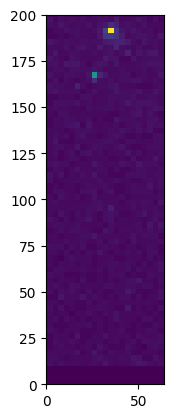

In [13]:
plt.imshow(V,  interpolation='none') # norm=LogNorm(),
plt.xlim(0,64)
plt.ylim(0,200)
plt.show()

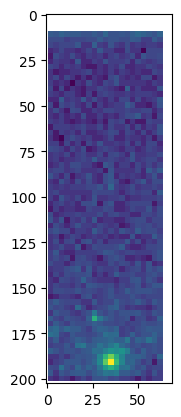

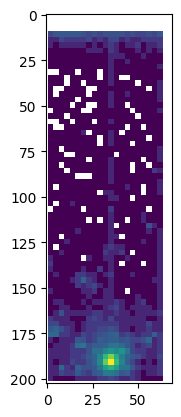

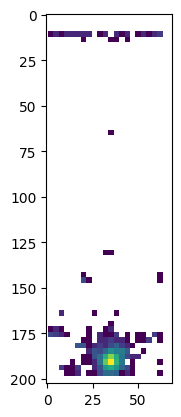

In [14]:
from matplotlib.colors import LogNorm
plt.imshow(c_max, norm=LogNorm(), interpolation='none')
plt.show()
plt.imshow(c_median, norm=LogNorm(), interpolation='none')
plt.show()
plt.imshow(c_min, norm=LogNorm(), interpolation='none')
plt.show()

In [15]:
def calculate_v(group):
    c_max = group['COUNT'].max()
    c_median = group['COUNT'].median()
    if c_median == 0:
        return c_max
    c_min = group['COUNT'].min()
    return max(c_max - c_median, c_median - c_min) / c_median

In [16]:
# Apply the V calculation for each (RAWX_GROUP, RAWY_GROUP) combination within each time-slice
result = df.groupby(['TIME_BIN', 'RAWX_GROUP', 'RAWY_GROUP']).apply(calculate_v).reset_index(name='V')

# Display the result
print(result)

/tmp/ipykernel_1876257/377894248.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result = df.groupby(['TIME_BIN', 'RAWX_GROUP', 'RAWY_GROUP']).apply(calculate_v).reset_index(name='V')


KeyError: 'COUNT'